# Data Augmentation

This is a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

In [15]:
from tensorflow.keras import backend as K
import gc

K.clear_session()   # 🧠 Clears Keras/TensorFlow model memory
gc.collect()        # 🧹 Cleans up everything else

0

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow import keras

In [17]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

In [18]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2025-06-29 21:30:24.765990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


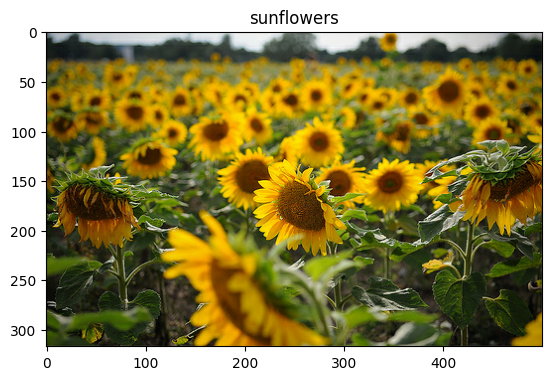

In [19]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds.skip(4).take(1)))
plt.imshow(image)
plt.title(get_label_name(label))
plt.show()

## Use Keras preprocessing layers  
  
Resizing and rescaling
You can use the Keras preprocessing layers to resize your images to a consistent shape (with tf.keras.layers.Resizing), and to rescale pixel values (with tf.keras.layers.Rescaling).

In [20]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

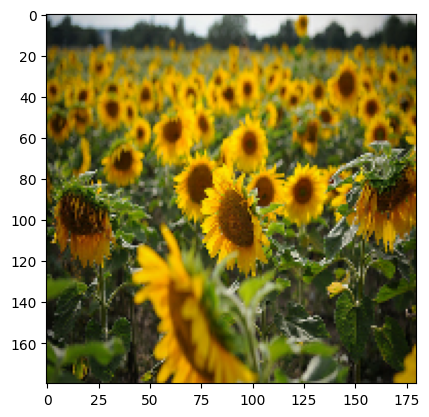

In [21]:
result = resize_and_rescale(image)
plt.imshow(result)
plt.show()

In [22]:
print("Min = %d and Max = %d pixel values" % (result.numpy().min(), result.numpy().max()))

Min = 0 and Max = 1 pixel values


## Data augmentation

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [24]:
# add the image to batch
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

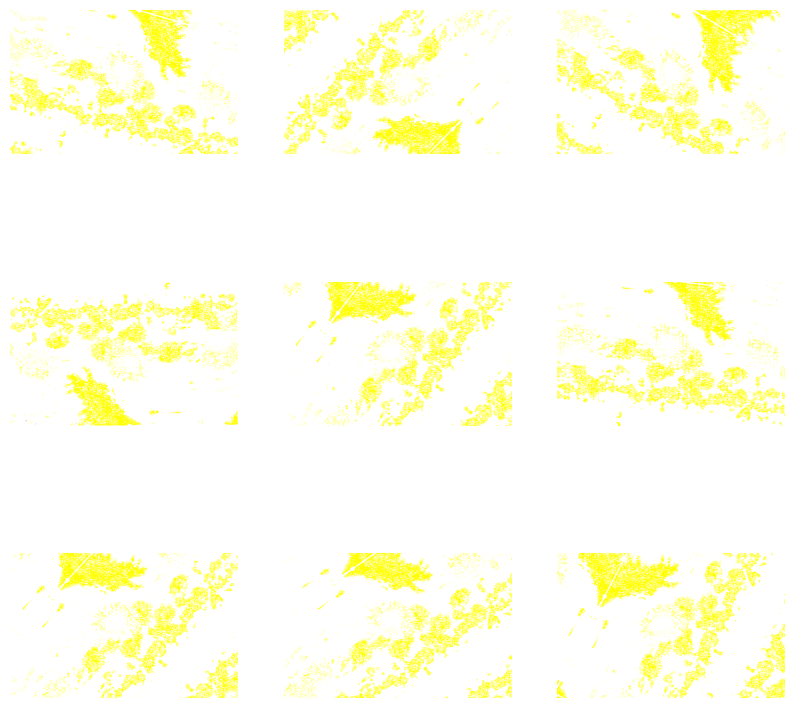

In [25]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')

# Two options to use the Keras preprocessing layers

### Option 1: Make the preprocessing layers part of your model

In [26]:
"""
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(180, 180, 3)),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D()
])
"""

"\nmodel = tf.keras.Sequential([\n    layers.InputLayer(input_shape=(180, 180, 3)),\n    resize_and_rescale,\n    data_augmentation,\n    layers.Conv2D(16, 3, padding='same', activation='relu'),\n    layers.MaxPooling2D()\n])\n"

### Option 2: Apply the preprocessing layers to your dataset

In [27]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

## Apply the preprocessing layers to the datasets

In [28]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

In [29]:
def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls = AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)
        
    # Batch all datasets
    ds = ds.batch(batch_size)
    
    # Use data augementation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x), y),
                    num_parallel_calls = AUTOTUNE)
        
    # Use buffered prefetching on all datasets
    return ds.prefetch(buffer_size = AUTOTUNE)

In [30]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

## Train a model  
The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for accuracy (the goal is to show you the mechanics).




In [31]:
model = keras.Sequential([
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

In [32]:
model.compile(optimizer = 'adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [33]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/5


2025-06-29 21:30:25.452223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.3637 - loss: 1.8427 - val_accuracy: 0.5477 - val_loss: 1.1270
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5699 - loss: 1.0759 - val_accuracy: 0.6185 - val_loss: 1.0269
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5994 - loss: 1.0374 - val_accuracy: 0.6349 - val_loss: 1.0193
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5601 - loss: 1.2840 - val_accuracy: 0.3243 - val_loss: 1.5604
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4998 - loss: 1.2681 - val_accuracy: 0.4387 - val_loss: 1.3876


In [34]:
history.history

{'accuracy': [0.44346049427986145,
  0.5844686627388,
  0.5970708727836609,
  0.49557220935821533,
  0.5149863958358765],
 'loss': [1.4222133159637451,
  1.0666334629058838,
  1.047541856765747,
  1.5469169616699219,
  1.291841745376587],
 'val_accuracy': [0.5476838946342468,
  0.6185286045074463,
  0.6348773837089539,
  0.3242506682872772,
  0.4386920928955078],
 'val_loss': [1.1269826889038086,
  1.0269372463226318,
  1.0192759037017822,
  1.5604054927825928,
  1.3875988721847534]}

In [35]:
loss, acc = model.evaluate(test_ds)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4951 - loss: 1.3256


In [36]:
acc

0.46866485476493835

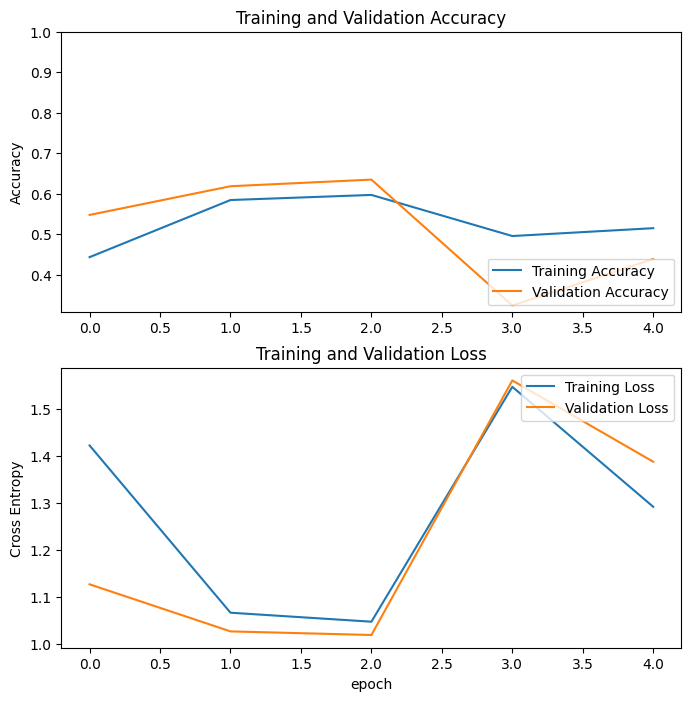

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

## Custom data augmentation
You can also create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

First, you will create a tf.keras.layers.Lambda layer. This is a good way to write concise code.
Next, you will write a new layer via subclassing, which gives you more control.
Both layers will randomly invert the colors in an image, according to some probability.

In [38]:
def random_invert_img(x, p = 0.5):
    if tf.random.uniform([]) < p:
        x = (255 - x)
    else:
        x
    return x

In [39]:
def random_invert(factor = 0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

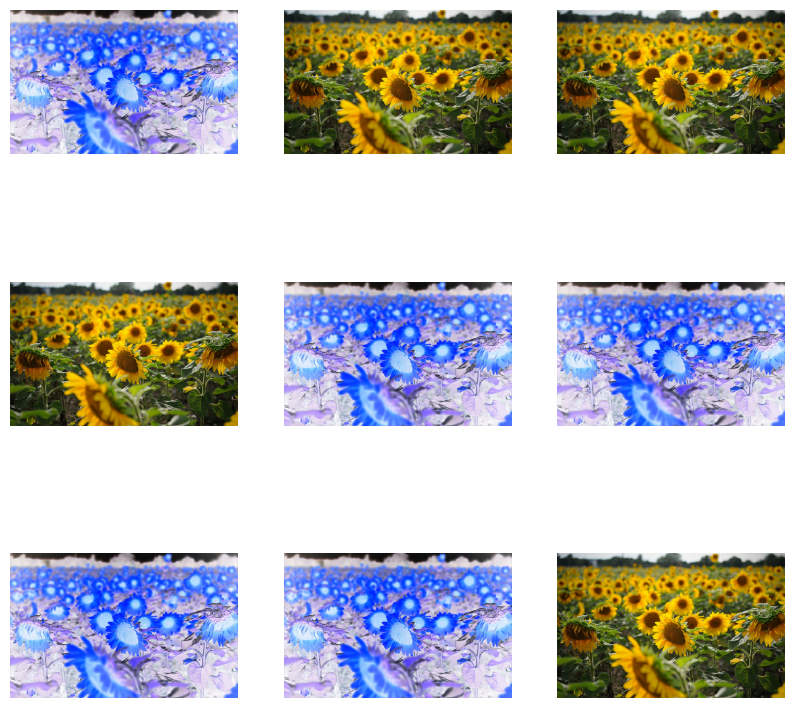

In [41]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')

In [49]:
class RandomInvert(layers.Layer):
    def __init__(self, factor = 0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
        
    def call(self, x):
        return random_invert_img(x)

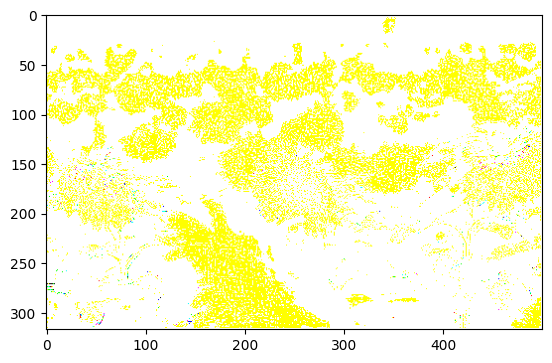

In [51]:
_ = plt.imshow(RandomInvert()(image)[0])